In [29]:
import datetime
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch

from blurr.text.data.all import *
from blurr.text.modeling.all import *
from fastai.data.block import RandomSplitter
from fastai.learner import load_learner
from transformers import BartForConditionalGeneration

# silence all the HF warnings
warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/team_007/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Grab our topics and transcripts

In [3]:
sheets_d = pd.read_excel(
    "../../data/raw/fsdl_2022_project_transcripts.xlsx",
    sheet_name=["lesson_topics", "lesson_transcripts"],
    engine="openpyxl",
)
topics_df, transcripts_df = [v for k, v in sheets_d.items()]

topics_df.drop(columns="video_url", inplace=True)
transcripts_df.drop(columns="video_url", inplace=True)

topics_df["timestamp"] = topics_df["timestamp"].astype(str)
transcripts_df["timestamp"] = transcripts_df["timestamp"].astype(str)

## Define a utility function for converting durations to total_seconds

In [4]:
def convert_duration_to_seconds(v):
    hrs, mins, secs = v.split(":")
    return (60 * 60 * int(hrs)) + (60 * int(mins)) + int(secs)

## Define the start/end boundaries (in seconds) for each topic in each lesson

In [5]:
topics_df["start_seconds"] = topics_df["timestamp"].apply(convert_duration_to_seconds)
topics_df["end_seconds"] = topics_df.groupby(by=["course_title", "lesson_num"])["start_seconds"].shift(
    -1, fill_value=100000
)

## Define the total number of elapsed seconds at each timestamp in the transcripts dataset

In [6]:
transcripts_df["elapsed_seconds"] = transcripts_df["timestamp"].apply(convert_duration_to_seconds)

In [7]:
transcripts_df.head()

,course_title,lesson_num,timestamp,transcript,elapsed_seconds
0,fast.ai 2022 - Part 1,2,00:00:00,"Hi everybody. Welcome to lesson two. Thanks for coming back… slight change of environment here,",0
1,fast.ai 2022 - Part 1,2,00:00:08,we had a bit of an “administrative issue” at our university — somebody booked our room — so I'm,8
2,fast.ai 2022 - Part 1,2,00:00:14,doing this from the study at home. so sorry about the lack of decorations behind me.,14
3,fast.ai 2022 - Part 1,2,00:00:25,I'm actually really really pumped about this lesson. It feels like going back to what things,25
4,fast.ai 2022 - Part 1,2,00:00:32,"were like in the very early days, because we're doing some really new, really cool stuff, which…",32


## Build our training data.  

This should be usable for both segmentation and summarization tasks

In [8]:
merged_df = topics_df[["course_title", "lesson_num", "topic", "start_seconds", "end_seconds"]].merge(
    transcripts_df, on=["course_title", "lesson_num"]
)
len(merged_df)

467129

Keep only the merged records where the transcript lies inbetween the start/end of the topic

In [9]:
merged_df = merged_df[
    (merged_df.elapsed_seconds >= merged_df.start_seconds) & (merged_df.elapsed_seconds < merged_df.end_seconds)
]

In [10]:
merged_df.head()

,course_title,lesson_num,topic,start_seconds,end_seconds,timestamp,transcript,elapsed_seconds
0,fast.ai 2022 - Part 1,2,Introduction,0,55,00:00:00,"Hi everybody. Welcome to lesson two. Thanks for coming back… slight change of environment here,",0
1,fast.ai 2022 - Part 1,2,Introduction,0,55,00:00:08,we had a bit of an “administrative issue” at our university — somebody booked our room — so I'm,8
2,fast.ai 2022 - Part 1,2,Introduction,0,55,00:00:14,doing this from the study at home. so sorry about the lack of decorations behind me.,14
3,fast.ai 2022 - Part 1,2,Introduction,0,55,00:00:25,I'm actually really really pumped about this lesson. It feels like going back to what things,25
4,fast.ai 2022 - Part 1,2,Introduction,0,55,00:00:32,"were like in the very early days, because we're doing some really new, really cool stuff, which…",32


For both segmentation and summarization tasks, we'll need to group the transcripts by course + lesson + topic

In [11]:
train_df = (
    merged_df[["course_title", "lesson_num", "topic", "transcript", "start_seconds"]]
    .groupby(by=["course_title", "lesson_num", "start_seconds", "topic"])
    .agg(list)
    .reset_index()
)

train_df.sort_values(by=["course_title", "lesson_num", "start_seconds"], inplace=True)

In [12]:
train_df.head()

,course_title,lesson_num,start_seconds,topic,transcript
0,C-Squared Podcast,1,0,Intro,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, christian well not so much fabi uh it's first of all great um to finally start a, podcast the chess podcast i know that um there's a lot of podcasts out there but, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been a..."
1,C-Squared Podcast,1,137,Candidates 2018,"[camps look like in general yeah well you mentioned the 2018 cycle uh where we worked together we started with the, training before the candidates and for me it's interesting because i've i've played a lot of these, candidates tournaments and i'm always doing it a bit differently trying different things trying to improve it but sometimes it goes, less or more successfully you never know what will work out i think what we did in 2018 not just for the candidates but, also for the world championship because i qualified for that i think what we did then was extremely successful, um we we arran..."
2,C-Squared Podcast,1,464,Candidates training,"[going in the candidates like how was the experience yeah i think the preparation was pretty serious it, included a bunch of uh camps and preparation devoted to players as i assume i think everyone has the same, sort of general approach which is to think about their openings their strategy look at the opponents try to, get in shape make sure that you're not you know rusty or blundering things or hallucinating, variations uh but there's a lot of nerves and i i felt a lot of nerves before the tournament and i think possibly i, you know overworked over trained a bit because it was yeah it was..."
3,C-Squared Podcast,1,610,Playing for 2nd place,"[were you just like focused on grabbing first well i was only focused on first, but of course there were always these thoughts that well maybe second is enough but you can't play for second, like let's say once i had achieved plus three in the tournament and john was plus four and i tried to go and go into like full, like risk reverse mode which is still difficult to do but let's say i had gone that mode and, and achieved it and like finished second with like plus three and john got plus five uh, and then like magnus says well i'm going to play right then you also feel kind of stupid you k..."
4,C-Squared Podcast,1,916,Magnus' WC decision,"[know you can't uh you can't tell him you have to do something i i guess let me rephrase that, fair to let you guys play the tournament first and then tell you the decision, well i think he said it in a strange way which was that i'll play against alireza, which to me is strange because if you don't want to play world championship match i fully understand you know but did he say that did he actually name him, yeah that's kind of what he said um yeah he more he like he didn't say definitively like i won't play against, anyone but he was like i probably won't play unless it's frozen right an..."


## Build summarization training set

In [13]:
summarization_train_df = train_df.copy()

In [14]:
summarization_train_df["transcript"] = summarization_train_df["transcript"].apply(
    lambda v: " ".join([str(seq) for seq in v])
)

In [15]:
summarization_train_df.head()

,course_title,lesson_num,start_seconds,topic,transcript
0,C-Squared Podcast,1,0,Intro,[Music] welcome everybody to episode one of a chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up christian well not so much fabi uh it's first of all great um to finally start a podcast the chess podcast i know that um there's a lot of podcasts out there but i wanted to bring our own tune to the mix and i think uh yeah i'm excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's been a while at your home it's good to be here it's my first time in uh visiting here and uh yeah it's been an intere...
1,C-Squared Podcast,1,137,Candidates 2018,camps look like in general yeah well you mentioned the 2018 cycle uh where we worked together we started with the training before the candidates and for me it's interesting because i've i've played a lot of these candidates tournaments and i'm always doing it a bit differently trying different things trying to improve it but sometimes it goes less or more successfully you never know what will work out i think what we did in 2018 not just for the candidates but also for the world championship because i qualified for that i think what we did then was extremely successful um we we arranged it...
2,C-Squared Podcast,1,464,Candidates training,going in the candidates like how was the experience yeah i think the preparation was pretty serious it included a bunch of uh camps and preparation devoted to players as i assume i think everyone has the same sort of general approach which is to think about their openings their strategy look at the opponents try to get in shape make sure that you're not you know rusty or blundering things or hallucinating variations uh but there's a lot of nerves and i i felt a lot of nerves before the tournament and i think possibly i you know overworked over trained a bit because it was yeah it was like ...
3,C-Squared Podcast,1,610,Playing for 2nd place,were you just like focused on grabbing first well i was only focused on first but of course there were always these thoughts that well maybe second is enough but you can't play for second like let's say once i had achieved plus three in the tournament and john was plus four and i tried to go and go into like full like risk reverse mode which is still difficult to do but let's say i had gone that mode and and achieved it and like finished second with like plus three and john got plus five uh and then like magnus says well i'm going to play right then you also feel kind of stupid you know li...
4,C-Squared Podcast,1,916,Magnus' WC decision,know you can't uh you can't tell him you have to do something i i guess let me rephrase that fair to let you guys play the tournament first and then tell you the decision well i think he said it in a strange way which was that i'll play against alireza which to me is strange because if you don't want to play world championship match i fully understand you know but did he say that did he actually name him yeah that's kind of what he said um yeah he more he like he didn't say definitively like i won't play against anyone but he was like i probably won't play unless it's frozen right and yeah...


In [16]:
summarization_train_df.shape

(597, 5)

## Plotting no of characters in topic and summary

<AxesSubplot: ylabel='Frequency'>

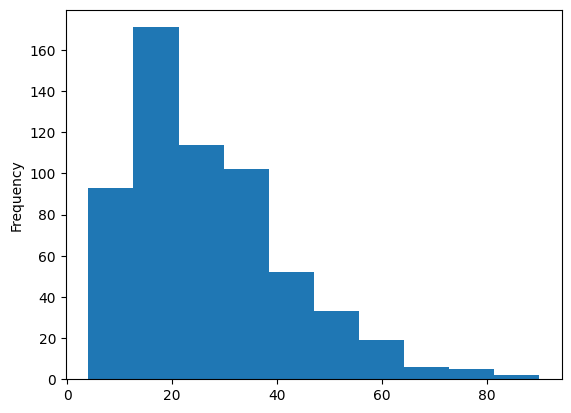

In [24]:
summarization_train_df["topic"].str.len().plot(kind="hist")

<AxesSubplot: ylabel='Frequency'>

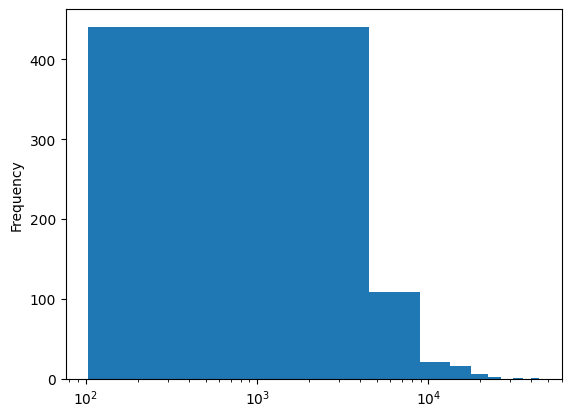

In [27]:
summarization_train_df["transcript"].str.len().plot(kind="hist", logx=True)

## Plotting no of words in topic and summary

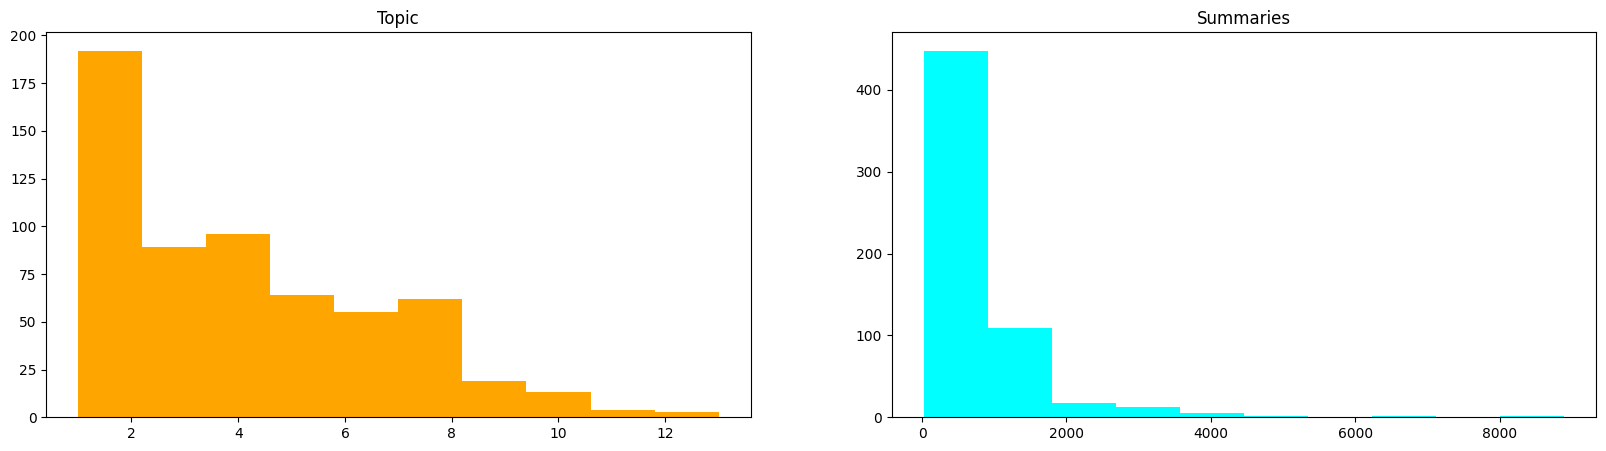

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
tweet_len = summarization_train_df["topic"].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color="orange")
ax1.set_title("Topic")
tweet_len = summarization_train_df["transcript"].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color="cyan")
ax2.set_title("Summaries")
plt.show()

## Blurr learner for training summarization model

In [17]:
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: Tesla V100-SXM2-16GB


In [18]:
learn = BlearnerForSummarization.from_data(
    summarization_train_df,
    "sshleifer/distilbart-cnn-6-6",
    text_attr="transcript",
    summary_attr="topic",
    max_length=512,
    max_target_length=100,
    dblock_splitter=RandomSplitter(),
    dl_kwargs={"bs": 32},
)

In [ ]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(15, lr_max=1e-5, cbs=[BlearnerForSummarization.get_metrics_cb()])

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,5.436864,5.236029,0.056225,0.009987,0.047669,0.051521,0.805305,0.859794,0.831513,00:32
1,5.134458,4.538479,0.061614,0.011636,0.051242,0.056747,0.807547,0.861833,0.833651,00:25
2,4.700820,3.919189,0.064631,0.015138,0.055143,0.058895,0.808703,0.862310,0.834489,00:25
3,4.324979,3.699072,0.062215,0.015581,0.055264,0.058591,0.809870,0.863322,0.835595,00:24
4,4.002648,3.549267,0.071016,0.019054,0.064074,0.068600,0.811739,0.865430,0.837570,00:24
5,3.729631,3.467210,0.073558,0.019054,0.065121,0.068618,0.810381,0.865496,0.836819,00:24
6,3.500593,3.403913,0.076443,0.022376,0.067799,0.073069,0.811572,0.867019,0.838190,00:24
7,3.293919,3.374657,0.073130,0.019060,0.067624,0.070439,0.811098,0.866646,0.837756,00:24
8,3.114873,3.356174,0.077777,0.020554,0.070461,0.074889,0.811736,0.866988,0.838249,00:24
9,2.961774,3.348094,0.082699,0.023341,0.076810,0.078583,0.811163,0.868057,0.838428,00:24


In [20]:
learn.summary()

BaseModelWrapper (Input shape: 32 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 17 x 1024      
Embedding                                 51470336   False     
Embedding                                 51470336   False     
____________________________________________________________________________
                     32 x 512 x 1024     
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
____________________________________________________________________________
                     32 x 512 x 4096     
Linear                       

## Model Export

In [28]:
learn.metrics = None
learn.export(fname="summarization_export.pkl")

## Predictions and taking look at results

In [21]:
learn.show_results(learner=learn, target_trunc_at=250)

In [22]:
test_article = """hey everybody welcome back this week we're going to talk about something a little bit different than we do most weeks most weeks we talk about specific
technical aspects of building machine learning powered products but this week we're going to focus on some of the
organizational things that you need to do in order to work together on ml-powered products as part of an
interdisciplinary team so the the reality of building ml Power Products is that building any product well is really
difficult you have to figure out how to hire grade people you need to be able to manage those people and get the best out
of them you need to make sure that your team is all working together towards a shared goal you need to make good
long-term technical choices manage technical debt over time you need to make sure that you're managing
expectations not just of your own team but also of leadership of your organization and you need to be able to make sure
that you're working well within the confines of the requirements of the rest of the org that you're understanding
those requirements well and communicating back to your progress to the rest of the organization against those requirements
but machine learning adds even more additional complexity to this machine learning Talent tends to be very scarce
and expensive to attract machine learning teams are not just a
single role but today they tend to be pretty interdisciplinary which makes managing them an even bigger challenge
machine learning projects often have unclear timelines and there's a high
degree of uncertainty to those timelines machine learning itself is moving super fast and machine learning as we've
covered before you can think of as like the high interest credit card of technical debt so keeping up with making
good long-term decisions and not incurring too much technical debt is especially difficult in ml unlike
traditional software ml is so new that in most organizations leadership tends not to be that well educated in it they
might not understand some of the core differences between ML and other technology that you're working with machine learning products tend to fail
in ways that are really hard for Lay people to understand and so that makes it very difficult to help the rest of
the stakeholders in your organization understand what they could really expect from the technology that you're building
and what is realistic for us to achieve so throughout the rest rest of this lecture we're going to kind of touch on
some of these themes and cover different aspects of this problem of working together to build ml Power Products as
an organization so here are the pieces that we're going to cover we're going to talk about different roles that are involved in building ml products we're
going to talk about some of the unique aspects involved in hiring ml Talent
we're going to talk about organization of teams and how the ml team tends to fit into the rest of the org and some of
the pros and cons of different ways of setting that up we'll talk about managing ml teams and
ml product management and then lastly we'll talk about some of the design considerations for how to design a
product that is well suited to having a good ml model that backs it so let's dive in and talk about rules the most
common ml rules that you might hear of are things like ml product manager ml
"""

In [31]:
inf_learn = load_learner(fname="summarization_export.pkl")

**Generation algorithms**

1. Beam search
2. Greedy search
3. Top -p sampling
4. Top k sampling

In [36]:
# Greedy
learn.predict(test_article, num_return_sequences=3, max_length=100)

[{'summary_texts': [' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team is really difficult',
   ' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team is very difficult',
   ' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team and your team']}]

In [37]:
# Beam search
learn.predict(test_article, num_return_sequences=3, num_beams=5, early_stopping=True)

[{'summary_texts': [' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams .',
   ' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams',
   ' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams.']}]

In [34]:
# Top -k sampling
learn.predict(test_article, num_return_sequences=3, do_sample=True, max_length=100, top_k=0)

[{'summary_texts': [' Introducing ML and ML (Machine Learning) Lessons & Hire/Hire, and Hire the Best Outgrade (ML) Team (Threatening) and Collaboration (ML/HBR) Learning, and Building Any Product Well (MLP)',
   ' What Do You Hire Your Team (ML/Supplier & Hire) & How To Hire ML Talent? (ML-Power Products) What Do We Hire The Team ( ML/Team Hire, ML, ML/Hire/Strategy) /MLP (MLP)',
   ' How to Hire the best people and manage the best out of the best teams and the rest of your team . Managing ML and ML projects is a big challenge for many of the people involved in the process of building ML products and managing ML products is really difficult']}]

In [35]:
# #Top -p sampling
learn.predict(test_article, do_sample=True, max_length=100, top_k=50, top_p=0.95, num_return_sequences=3)

[{'summary_texts': [' How to Hire and Hire the best people you need to hire in order to build a team of ML-powered products. What is realistic to achieve throughout the rest of this lecture is that building any product well is reallydifficult. How to hire a team',
   ' Introduction and Hire & Hire (Hire/Hire, Hire, & Design & Design (ML, and ML) Back to Mail Online: Introduction, Hiring, and Hiring ML Talent (Punish & Design, and Building ML)',
   ' What Is ML (Machine Learning) Leadership, Hire & Hire/Hire, and Design & Design (ML/Design, and ML/Design) Back to Mail Online home. Back to the page you came from.com/Manufacturing/Hobby/Design']}]

In [25]:
test_article1 = """hey everybody we're getting ready to start here everyone's click in on putting my shirt on here oh my dress shirt I was always wearing clothes ok and 3 2 1 boom mics on everything we're ready to go welcome ladies and gentlemen back to my studio here in Vancouver Canada my name is Michael Markowski I'm gonna be showing you how to do some drawing today I'm super excited because I think today we're really going to learn a lot about how to take all these different techniques we've been doing over the past three classes so far put them together to make some new drawings that are gonna really excite us and you're I think you're really gonna be surprised by how much you already know I mean based on just what we've learned so far so we're gonna put it all together and to create some new artworks let me see I'm just gonna turn this light on here okay so let me see what are the little housekeeping things I want to get cleared away right at the beginning if you have any drawings you'd like for me to see and to critique and to give you feedback on please send them to my Instagram to my Twitter or Facebook and if you do so please in the comments say tell me where it is so that I can kind of take a look for it and find it and I'll give you some feedback at the end of the episode in about one hour and that'll be a because some because the formal lesson is gonna be about an hour and then at the Rianne there's some time for chat and for asking me all sorts of other random questions that maybe haven't been answered yet so please do that I see there's already a couple of people who've who've uploaded drawing so I'm excited to check those out and to and to help maybe they're already perfect I haven't seen them yet so let's I can't wait to do that other things if you like this video please like the video subscribe hit the notification bell and if you're really really excited and you want to support the channel please send a dollar or $100 or the keys to your boat through the PayPal link in below yeah and my wife's is there following along she says yep Markowski art mark-1 osky art is my links on every social media that I know of and they're all in the description below I digress okay so are you ready to do some drawing you've got your pencils and you've got your erasers I don't get that out here all of this stuff here I'm currently in the 	:52:09 Shading a """

In [26]:
learn.predict(test_article1, num_return_sequences=3)

[{'summary_texts': [' Introduction to Art Class #1 (Michael Markowski) (Markowski) #1: Introduction: Introduction, Introduction, Discussion, Criticism, Critique, Viewer Comments, etc. Send your feedback to my Instagram, Twitter, Facebook, Twitter or Facebook',
   ' Introduction to Art Class #1 (Michael Markowski) (Markowski) #1: Introduction: Introduction, Introduction, Discussion, Criticism, Critique, Viewer Comments, etc. Send your feedback to my Instagram, Twitter, Facebook, Twitter and Facebook',
   ' Introduction to Art Class #1 (Michael Markowski) (Markowski) #1: Introduction: Introduction, Introduction, Discussion, Criticism, Critique, Viewer Comments, etc. Send your feedback to my Instagram, Twitter, Facebook, Twitter and Twitter']}]

In [39]:
learn.predict(test_article, num_return_sequences=3, max_length=100)

[{'summary_texts': [' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team is really difficult',
   ' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team is very difficult',
   ' How to Hire the best people and get the best out of the best of your team (MLs, MLs, and MLs) The reality of building a product well is that building any product well in order to be able to manage your team and your team']}]

In [40]:
# Beam search
learn.predict(test_article, num_return_sequences=3, num_beams=5, early_stopping=True)

[{'summary_texts': [' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams .',
   ' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams',
   ' How to Hire the best people and get the best out of the people you need to hire and manage your team . Building any product well is reallydifficult and managing ML projects as part of an interdisciplinary team is a big challenge for ML teams and ML teams.']}]

In [42]:
# Top -p sampling
learn.predict(test_article, do_sample=True, max_length=100, top_k=50, top_p=0.95, num_return_sequences=3)

[{'summary_texts': [' Introducing ML vs. ML (Conference of Systems, Tools, and Design, and ML (Machine Learning, ML, and Pupilization, and Other Roles) Back to the page you came from this week’s lecture and What Is ML',
   ' How To Hire Your Team (ML Teams) Back to Mail Online: Introduction and Hire ML Talent (Hire the best people, managers, etc. etc. Back to the page you came from this week’s lecture (ML/ML/Supplier)',
   ' Introduction and Discussion of ML and Hire & Hire #1 (ML, Hire, & Design, ML, and ML/Hire, ML/Design, & ML/ Hire/Design (ML/HIP/ML, etc. What are the key factors involved in hiring ML Teams?']}]

In [41]:
learn.predict(test_article1, num_return_sequences=3, do_sample=True, max_length=100, top_k=0)

[{'summary_texts': [' Yep Markowski Art Class #1 (Markowski Art Markowski) (Doodles, erasers, etc. Shading, Housekeeping, and Housekeeping) (Markowoodles) (2 1 boom mics) (3 1 boom Mics)',
   ' How to Draw Art in the Rianne - Michael Markowski Art Markowski Show #1 Osky Art (1/1/2/1 /1/3/1) & #1/4/1 (Markowski/1-1) #1 osky art (3/2)',
   ' Introduction #1 (Michael Markowski) Posted by Michael Markowski on Twitter, Instagram, Facebook, Twitter, Twitter and Facebook @Markowski Art Markowski (Markowski) #1/1 (Markowowski) / #1 Osky Art (Mark']}]

In [38]:
test_article1

"hey everybody we're getting ready to start here everyone's click in on putting my shirt on here oh my dress shirt I was always wearing clothes ok and 3 2 1 boom mics on everything we're ready to go welcome ladies and gentlemen back to my studio here in Vancouver Canada my name is Michael Markowski I'm gonna be showing you how to do some drawing today I'm super excited because I think today we're really going to learn a lot about how to take all these different techniques we've been doing over the past three classes so far put them together to make some new drawings that are gonna really excite us and you're I think you're really gonna be surprised by how much you already know I mean based on just what we've learned so far so we're gonna put it all together and to create some new artworks let me see I'm just gonna turn this light on here okay so let me see what are the little housekeeping things I want to get cleared away right at the beginning if you have any drawings you'd like for m